# Treinamento de modelo de OCR (Optical Character Recognition)


## Instala a biblioteca [Albumentations](https://github.com/albumentations-team/albumentations)

In [1]:
!pip install albumentations

     |████████████████████████████████| 634kB 2.8MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=d32bbe913bcdbe0f75b05ed6a59bb9b1cc5aefa8dadb6e0b072507ff5cf2d72d
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


## Importa as libs e métodos necessárias para treinar o modelo

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.utils.data_utils import Sequence
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda, InputLayer
from keras.models import model_from_json
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
import h5py
import string
from albumentations import (Compose, Rotate, Blur, RandomBrightnessContrast, IAAPerspective, RandomScale)

Using TensorFlow backend.


## Define funções e classes para utilização posterior

In [0]:
# Classe para treinar o modelo com Augmentação dos dados
class DataAgumented(Sequence):
  def __init__(self, images, labels, batch_size, augmentator):
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.augmentator = augmentator

  def __len__(self):
    number_of_batches = np.ceil(len(self.images) / float(self.batch_size))
    return int(number_of_batches)

  def __getitem__(self, idx):
    images_batch = self.images[idx * self.batch_size : (idx + 1) * self.batch_size]
    labels_batch = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]

    augmented_batch = [self.augmentator(image = image)["image"]  for image in images_batch]
    return np.stack(augmented_batch, axis = 0), np.array(labels_batch)

In [0]:
# Função de leitura do arquivo hdf5
def read_hdf5_dataset(path_to_hdf5):
    hdf5_dataset = h5py.File(path_to_hdf5, "r")
    characters_images = hdf5_dataset["characters_images"]
    characters_labels = hdf5_dataset["labels"]
    
    return hdf5_dataset, (characters_images, characters_labels)

In [0]:
# Função para plotar as métricas observadas durante o treinamento e teste do modelo
def plot_training_metrics(history):
  fig, ax1 = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 10))
  # Printa acurácia para treino e teste
  ax1[0].plot(history.history['accuracy'])
  ax1[0].plot(history.history['val_accuracy'])
  ax1[0].set_title("Accuracy x Epochs", fontsize = 20)
  ax1[0].set_ylabel('accuracy', fontsize = 20)
  ax1[0].set_xlabel('epoch', fontsize = 20)
  ax1[0].legend(['train', 'test'], loc='upper right', prop = {"size" : 15})
  # Printa loss para treino e teste
  ax1[1].plot(history.history['loss'])
  ax1[1].plot(history.history['val_loss'])
  ax1[1].set_title("Loss x Epochs", fontsize = 20)
  ax1[1].set_ylabel('loss', fontsize = 20)
  ax1[1].set_xlabel('epoch', fontsize = 20)
  ax1[1].legend(['train', 'test'], loc='upper right', prop = {"size" : 15})

## Efetua a leitura do dataset e separa em letras e números

In [6]:
NUMBERS = [str(i) for i in range(10)]
LETTERS = list(string.ascii_uppercase)
print("NUMBERS => ", NUMBERS)
print("LETTERS => ", LETTERS)

NUMBERS =>  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
LETTERS =>  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [0]:
dataset, (characters_images, characters_labels) = read_hdf5_dataset("/content/drive/My Drive/Colab Notebooks/characters_dataset.hdf5")

In [0]:
image_data = np.array(characters_images)
label_data = np.array(characters_labels)

In [0]:
# Filtra os indices das labels (Letras x Numeros)
letter_indexes = np.nonzero(np.isin(label_data, LETTERS))
number_indexes = np.nonzero(np.isin(label_data, NUMBERS))

## Treina um modelo para reconhecimento dos números

In [0]:
INPUT_SHAPE = (80, 55, 3) #(height, width, channels)
BATCH_SIZE = 500
EPOCHS = 5
NUMBER_OF_CLASSES = len(NUMBERS)

In [0]:
# Separa os dados em treino (80%) e teste (20%)
test_idx = int(len(label_data[number_indexes]) * 0.8)
train_images = image_data[number_indexes][ :test_idx]
test_images = image_data[number_indexes][test_idx: ]
train_labels = label_data[number_indexes][ :test_idx]
test_labels = label_data[number_indexes][test_idx: ]

In [12]:
# Converte as classes para um vetor de classes (Padrão one-hot-encoding)
print("Before => ", train_labels)
train_labels = keras.utils.to_categorical(train_labels, NUMBER_OF_CLASSES)
test_labels = keras.utils.to_categorical(test_labels, NUMBER_OF_CLASSES)
print("After => ", train_labels)

Before =>  ['2' '3' '5' ... '4' '8' '3']
After =>  [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
# Arquitetura da rede
model = Sequential()
model.add(Lambda( lambda image: image * (1/255.0),  input_shape = INPUT_SHAPE))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUMBER_OF_CLASSES, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 80, 55, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 53, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 76, 51, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 25, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 25, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 60800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

In [0]:
# Instancia os geradores de imagens augmentadas
AUGMENTATOR = Compose(  [Rotate(15), Blur(5), IAAPerspective(scale = (0.025, 0.05), p = 0.8),
                        RandomBrightnessContrast(brightness_limit = 0.35, contrast_limit = 0.35)], 
                        p = 0.7 )
train_generator = DataAgumented(train_images, train_labels, batch_size = BATCH_SIZE, augmentator = AUGMENTATOR)
test_generator = DataAgumented(test_images, test_labels, batch_size = BATCH_SIZE, augmentator = AUGMENTATOR) 

In [16]:
# Treina o modelo
history = model.fit(train_generator,
          epochs = EPOCHS,
          verbose=1,
          validation_data = test_generator)

Epoch 1/5
31/31 [==============================] - 37s 1s/step - loss: 1.2082 - accuracy: 0.6208 - val_loss: 0.1840 - val_accuracy: 0.9543
Epoch 2/5
31/31 [==============================] - 34s 1s/step - loss: 0.1240 - accuracy: 0.9671 - val_loss: 0.0066 - val_accuracy: 0.9990
Epoch 3/5
31/31 [==============================] - 35s 1s/step - loss: 0.0497 - accuracy: 0.9872 - val_loss: 0.0014 - val_accuracy: 0.9997
Epoch 4/5
31/31 [==============================] - 33s 1s/step - loss: 0.0351 - accuracy: 0.9896 - val_loss: 0.0018 - val_accuracy: 0.9995
Epoch 5/5
31/31 [==============================] - 32s 1s/step - loss: 0.0294 - accuracy: 0.9917 - val_loss: 8.0299e-04 - val_accuracy: 0.9990


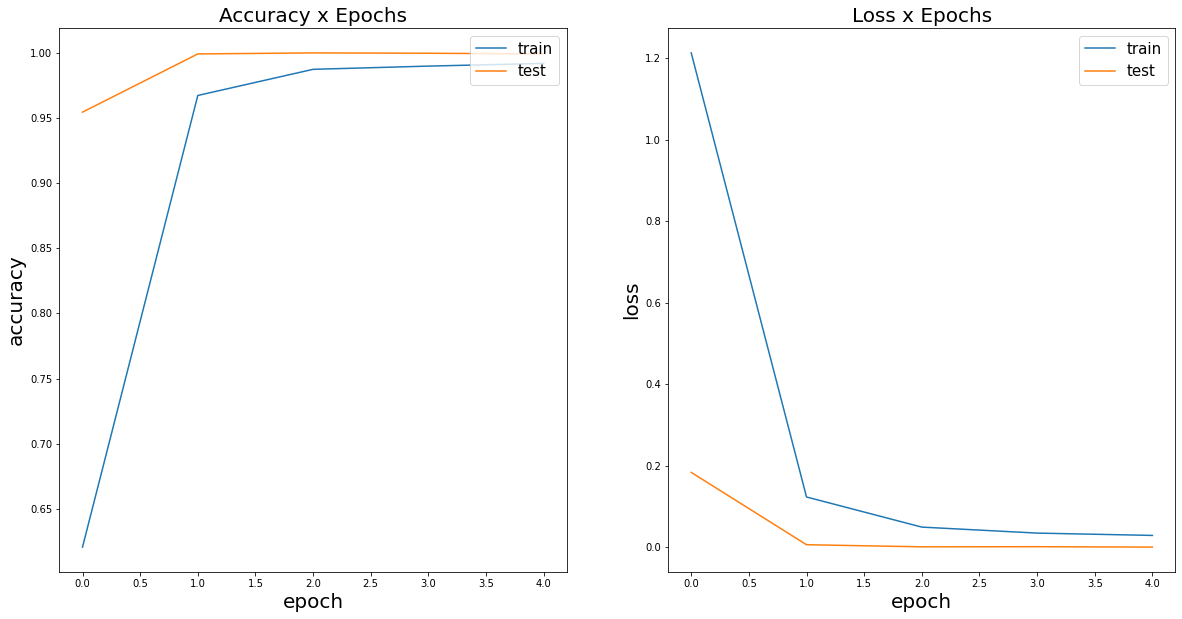

In [17]:
plot_training_metrics(history)

In [0]:
model.save("/content/drive/My Drive/Colab Notebooks/ocr_models/numbers_model.h5")

## Treina um modelo para reconhecimento das letras

In [0]:
INPUT_SHAPE = (80, 55, 3) #(height, width, channels)
BATCH_SIZE = 500
EPOCHS = 5
NUMBER_OF_CLASSES = len(LETTERS)

In [0]:
# Separa os dados em treino (80%) e teste (20%)
test_idx = int(len(label_data[letter_indexes]) * 0.8)
train_images = image_data[letter_indexes][ :test_idx]
test_images = image_data[letter_indexes][test_idx: ]
train_labels = label_data[letter_indexes][ :test_idx]
test_labels = label_data[letter_indexes][test_idx: ]

In [21]:
# Converte as classes para um vetor de classes (Padrão one-hot-encoding), porém como são strings, devemos antes mapear cada string para uma valor em inteiro
letters_mapping = {letter : idx for idx,letter in enumerate(LETTERS)}
print("Letters mapping => ", letters_mapping)
print("Train labels before mapping => ", train_labels)
train_labels = [letters_mapping[label] for label in train_labels]
test_labels = [letters_mapping[label] for label in test_labels]
print("Train labels after mapping => ", train_labels[:10])
train_labels = keras.utils.to_categorical(train_labels, NUMBER_OF_CLASSES)
test_labels = keras.utils.to_categorical(test_labels, NUMBER_OF_CLASSES)

Letters mapping =>  {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
Train labels before mapping =>  ['U' 'T' 'U' ... 'G' 'J' 'D']
Train labels after mapping =>  [20, 19, 20, 19, 11, 25, 2, 8, 25, 17]


In [0]:
# Arquitetura da rede
model = Sequential()
model.add(Lambda( lambda image: image * (1/255.0), input_shape = INPUT_SHAPE ))
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(NUMBER_OF_CLASSES, activation = 'softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 80, 55, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 78, 53, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 76, 51, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 25, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 38, 25, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 60800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

In [0]:
# Instancia os geradores de imagens augmentadas
AUGMENTATOR = Compose(  [Rotate(15), Blur(5), IAAPerspective(scale = (0.025, 0.05), p = 0.8),
                        RandomBrightnessContrast(brightness_limit = 0.35, contrast_limit = 0.35)], 
                        p = 0.7 )
train_generator = DataAgumented(train_images, train_labels, batch_size = BATCH_SIZE, augmentator = AUGMENTATOR)
test_generator = DataAgumented(test_images, test_labels, batch_size = BATCH_SIZE, augmentator = AUGMENTATOR) 

In [25]:
# Treina o modelo
history = model.fit(train_generator,
          epochs = EPOCHS,
          verbose=1,
          validation_data = test_generator)

Epoch 1/5
161/161 [==============================] - 167s 1s/step - loss: 0.7036 - accuracy: 0.7889 - val_loss: 0.0041 - val_accuracy: 0.9971
Epoch 2/5
161/161 [==============================] - 158s 979ms/step - loss: 0.0547 - accuracy: 0.9825 - val_loss: 0.0104 - val_accuracy: 0.9992
Epoch 3/5
161/161 [==============================] - 158s 982ms/step - loss: 0.0300 - accuracy: 0.9896 - val_loss: 1.0322e-04 - val_accuracy: 0.9994
Epoch 4/5
161/161 [==============================] - 160s 991ms/step - loss: 0.0228 - accuracy: 0.9921 - val_loss: 1.3897e-05 - val_accuracy: 0.9997
Epoch 5/5
161/161 [==============================] - 159s 985ms/step - loss: 0.0206 - accuracy: 0.9931 - val_loss: 2.3332e-06 - val_accuracy: 0.9998


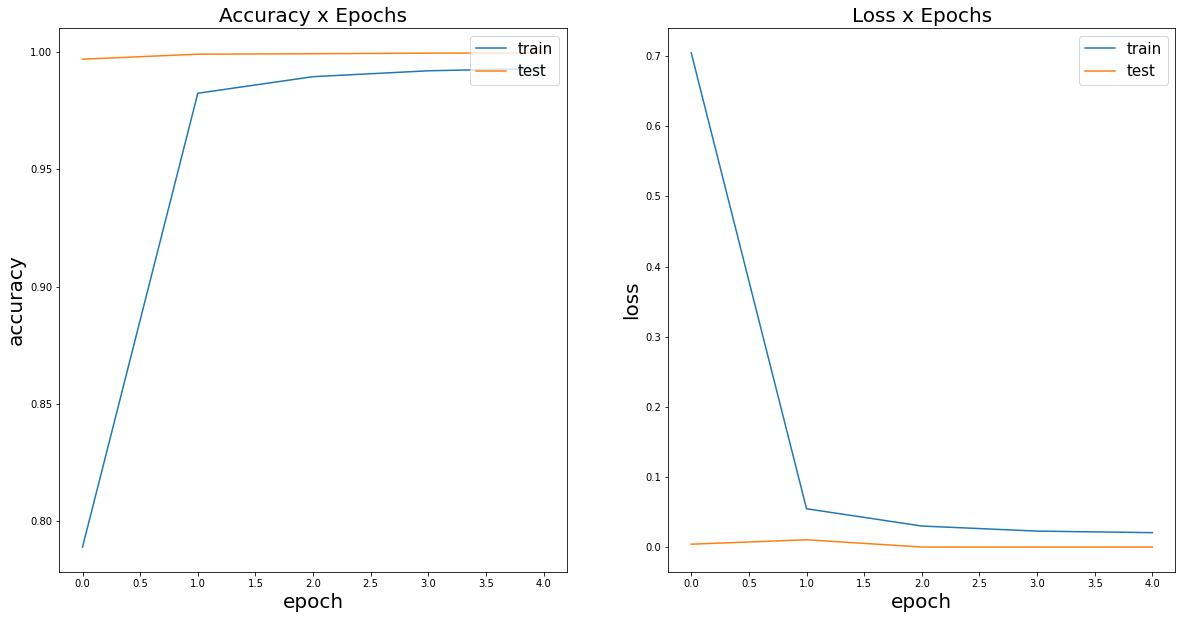

In [26]:
plot_training_metrics(history)

In [0]:
model.save("/content/drive/My Drive/Colab Notebooks/ocr_models/letters_model.h5")

## Fecha o dataset hdf5

In [0]:
dataset.close()